# Trying architecture found in https://hackernoon.com/training-an-image-classifier-from-scratch-in-15-minutes-3c140f5fa1af

In [1]:
from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers import Activation, Flatten, Dense, Dropout
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras import regularizers

import keras
from keras.models import Model
from keras.layers import Dropout, Flatten, Input, AveragePooling2D, merge, Activation, ReLU, Lambda
from keras.layers import Conv2D,SeparableConv2D, MaxPooling2D, BatchNormalization
from keras.layers import concatenate

import tensorflow as tf
#import tensorflow.keras.callbacks.ReduceLROnPlateau

from keras.callbacks import ReduceLROnPlateau

Using TensorFlow backend.


In [2]:
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train,img_rows, img_cols,img_channels =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

170500096/170498071 [==============================] - 2s 0us/step


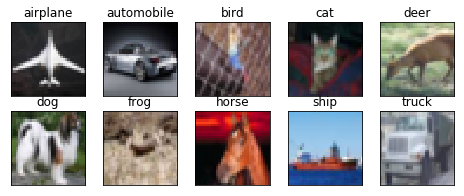

In [3]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

In [0]:
#Convert the images in training dataset and test set into multidimentional arrays of their pixel intensity values.

train_features = train_features.reshape(train_features.shape[0], 32, 32,3)
test_features = test_features.reshape(test_features.shape[0], 32, 32,3)

In [0]:
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

In [0]:
channelsize = 32
def res_blk(input,blockname, factor):
    
    c1 = BatchNormalization(name=(blockname+'norm_1'))(input)
    c1_r = ReLU(max_value=None, negative_slope=0.0, threshold=0.0)(c1)
    c1 = Conv2D(channelsize*factor, (1, 1), strides=(1, 1), padding='same', name=(blockname+'conv_1'), use_bias=False)(c1_r)
    
    
    c1 = BatchNormalization(name=(blockname+'norm_2'))(c1)
    c1 = ReLU(max_value=None, negative_slope=0.0, threshold=0.0)(c1)
    c1 = Conv2D(channelsize*factor, (1, 1), strides=(1, 1), padding='same', name=(blockname+'conv_2'), use_bias=False)(c1)
    
    #concat_layer = Concatenate(axis=-1)([c1,c1_r], name = (blockname + 'concat_1'))
    concat_layer = concatenate([c1, c1_r], axis=-1, name = (blockname + 'concat_1'))
    return concat_layer


def res_blk_g1(input,blockname, factor):
    
    c1 = BatchNormalization(name=(blockname+'norm_1'))(input)
    c1_r = ReLU(max_value=None, negative_slope=0.0, threshold=0.0)(c1)
    c1 = Conv2D(channelsize*factor, (1, 1), strides=(1, 1), padding='same', name=(blockname+'conv_1'), use_bias=False)(c1_r)
    
    
    c1 = BatchNormalization(name=(blockname+'norm_2'))(c1)
    c1 = ReLU(max_value=None, negative_slope=0.0, threshold=0.0)(c1)
    c1 = Conv2D(channelsize*factor, (1, 1), strides=(1, 1), padding='same', name=(blockname+'conv_2'), use_bias=False)(c1)
    
    c2 = Conv2D(channelsize*factor, (1, 1), strides=(1, 1), padding='same', name=(blockname+'conv_3'), use_bias=False)(c1_r)
    
    
    #concat_layer = Concatenate(axis=-1)([c1,c2], name = (blockname + 'concat_1'))
    concat_layer = concatenate([c1, c2], axis=-1, name = (blockname + 'concat_1'))
    return concat_layer


def res_blk_g2_3(input,blockname, factor):
    
    c1 = BatchNormalization(name=(blockname+'norm_1'))(input)
    c1_r = ReLU(max_value=None, negative_slope=0.0, threshold=0.0)(c1)
    c1 = Conv2D(channelsize*factor, (1, 1), strides=(1, 1), padding='same', name=(blockname+'conv_1'), use_bias=False)(c1_r)
    c1 = MaxPooling2D(pool_size=(2,2), name = (blockname+'MP_1'))(c1)
    
    c1 = BatchNormalization(name=(blockname+'norm_2'))(c1)
    c1 = ReLU(max_value=None, negative_slope=0.0, threshold=0.0)(c1)
    c1 = Conv2D(channelsize*factor, (1, 1), strides=(1, 1), padding='same', name=(blockname+'conv_2'), use_bias=False)(c1)
    
    c2 = Conv2D(channelsize*factor, (1, 1), strides=(1, 1), padding='same', name=(blockname+'conv_3'), use_bias=False)(c1_r)
    c2 = MaxPooling2D(pool_size=(2,2), name = (blockname+'MP_2'))(c2)
    
    #concat_layer = Concatenate(axis=-1)([c1,c2], name = (blockname + 'concat_1'))
    concat_layer = concatenate([c1, c2], axis=-1, name = (blockname + 'concat_1'))
    return concat_layer


In [0]:
def create_model(input_shape,nb_classes=10):
    input = Input(shape=input_shape)
    
    prep_conv = Conv2D(16, (1, 1), strides=(1, 1), padding='same', name='prep_conv', use_bias=False)(input)
    
    blk1_1=res_blk_g1(prep_conv,'RS1_1', 1)
    blk1_2=res_blk(blk1_1,'RS1_2', 1)
    blk1_3=res_blk(blk1_2,'RS1_3', 1)
    
    blk2_1=res_blk_g2_3(blk1_3,'RS2_1', 2)
    blk2_2=res_blk(blk2_1,'RS2_2', 2)
    blk2_3=res_blk(blk2_2,'RS2_3', 2)
    
    
    blk3_1=res_blk_g2_3(blk2_3,'RS3_1', 4)
    blk3_2=res_blk(blk3_1,'RS3_2', 4)
    blk3_3=res_blk(blk3_2,'RS3_3', 4)
    
    x1 = BatchNormalization(name=('FinalBN'))(blk3_3)
    
    x1 = ReLU(max_value=None, negative_slope=0.0, threshold=0.0)(x1)
    
    x1 = Conv2D(nb_classes, (1, 1), strides=(1, 1), name='Final1_1', use_bias=False)(x1)
    # Once the Resolution is less than 9x9, convolution with 3x3 will not cover all the pixels.
    # So convolve with whatever is the size of the input channel i.e. 8x8 convolution
    x1 = Conv2D(nb_classes, (8, 8), strides=(1, 1), name='FinalConv', use_bias=False)(x1)
    
    #x1 = GlobalAveragePooling2D(dim_ordering=axis)(x1)
    
    flattenedoutput = Flatten()(x1)
    output = Activation('softmax')(flattenedoutput)
    model = Model(inputs=[input], outputs=[output])
    return model
    
    
    

In [8]:
model = create_model((img_rows,img_cols,img_channels), num_classes)

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

W0811 22:26:10.142290 139804802299776 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0811 22:26:10.185259 139804802299776 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0811 22:26:10.191971 139804802299776 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0811 22:26:10.226553 139804802299776 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0811 22:26:10.227305 1398048022

In [9]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
prep_conv (Conv2D)              (None, 32, 32, 16)   48          input_1[0][0]                    
__________________________________________________________________________________________________
RS1_1norm_1 (BatchNormalization (None, 32, 32, 16)   64          prep_conv[0][0]                  
__________________________________________________________________________________________________
re_lu_1 (ReLU)                  (None, 32, 32, 16)   0           RS1_1norm_1[0][0]                
__________________________________________________________________________________________________
RS1_1conv_

In [0]:

def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [0]:

def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., callbacks=[<keras.ca..., verbose=1, steps_per_epoch=195, epochs=25)`
  del sys.path[0]
W0811 22:26:15.131906 139804802299776 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprec

Epoch 1/25
195/195 [==============================] - 35s 181ms/step - loss: 1.6459 - acc: 0.4169 - val_loss: 1.6077 - val_acc: 0.4625
Epoch 2/25
195/195 [==============================] - 29s 148ms/step - loss: 1.3218 - acc: 0.5320 - val_loss: 1.3618 - val_acc: 0.5183
Epoch 3/25
195/195 [==============================] - 29s 148ms/step - loss: 1.2428 - acc: 0.5618 - val_loss: 1.3347 - val_acc: 0.5333
Epoch 4/25
195/195 [==============================] - 29s 149ms/step - loss: 1.1948 - acc: 0.5774 - val_loss: 1.3022 - val_acc: 0.5418
Epoch 5/25
195/195 [==============================] - 29s 150ms/step - loss: 1.1487 - acc: 0.5941 - val_loss: 1.2727 - val_acc: 0.5545
Epoch 6/25
195/195 [==============================] - 29s 150ms/step - loss: 1.1194 - acc: 0.6044 - val_loss: 1.2985 - val_acc: 0.5482
Epoch 7/25
195/195 [==============================] - 29s 150ms/step - loss: 1.0916 - acc: 0.6162 - val_loss: 1.2658 - val_acc: 0.5650
Epoch 8/25
195/195 [==============================] - 2

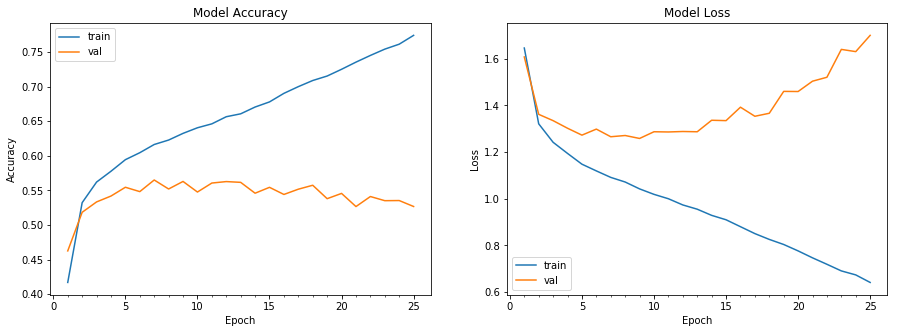

Accuracy on test data is: 52.67


In [12]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(zoom_range=0.0, 
                             horizontal_flip=False)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)

# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 256),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 25, 
                                 validation_data = (test_features, test_labels), callbacks=[reduce_lr], verbose=1)
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))